<a href="https://colab.research.google.com/github/gilbertoknd/AI_For_Games/blob/main/Testing_Double_Deep_Q_Learning_SpaceInvaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Double Deep Q-Learning for Space Invaders (PyTorch)

In this notebook, we will use Deep Q-Learning to solve Space Invaders.


Environment: (https://gymnasium.farama.org/environments/atari/space_invaders/).

Paper: (https://arxiv.org/abs/1509.06461v3).

##Setup

In [ ]:
%%capture
!pip install gymnasium[atari]
!pip install autorom[accept-rom-license]
!pip install pytorch
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
import numpy as np

Importing PyTorch neural network (torch.nn) and optimizer (torch.optim)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Install Space Invaders ROM

In [ ]:
# Get ROM
from ale_py import ALEInterface
# ale = ALEInterface()

# from ale_py.roms import SpaceInvaders
# ale.loadROM(SpaceInvaders)

## Setup a Virtual Display
To generate a replay video of agent and environment.

In [ ]:
# Virtual display
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Let's start by creating the Space Invaders environment.
env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
env.spec

EnvSpec(id='ALE/SpaceInvaders-v5', entry_point='ale_py.env:AtariEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, disable_env_checker=False, kwargs={'game': 'space_invaders', 'repeat_action_probability': 0.25, 'full_action_space': False, 'frameskip': 4, 'max_num_frames_per_episode': 108000, 'render_mode': 'rgb_array'}, namespace='ALE', name='SpaceInvaders', version=5, additional_wrappers=(), vector_entry_point='ale_py.vector_env:AtariVectorEnv')

##Observing the environment

In [ ]:
print("Actions:", env.unwrapped.get_action_meanings())

Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [ ]:
def plot_image(plot, render, cmap=None):
  plot.imshow(render, cmap)
  plot.show()

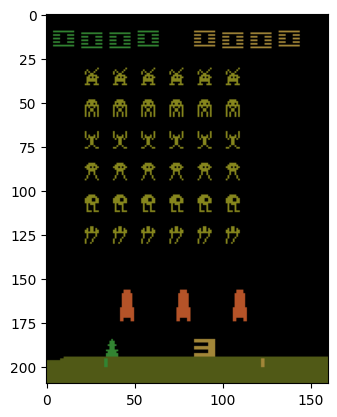

In [ ]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the Space Invaders scenario
env.reset()
for i in range(21):
    state, reward, terminated, truncated, info = env.step(1)
plot_image(plt,state)

##Executing random actions

In [ ]:
# Taking a step by selecting a random action from current state
# next_observation: next frames of the game
# reward: What rewards did I receive?
# terminated: did I end up in the goal state?
# truncated: did I end up in the max number of steps?

print("step number: action, state, reward, terminated, truncated, {info}")

for i in range(1):
    # sample a random action from all valid actions
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("step", i+1, ":", env.unwrapped.get_action_meanings()[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

step number: action, state, reward, terminated, truncated, {info}
step 1 : RIGHT , [[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[80 89 22]
  [80 89 22]
  [80 89 22]
  ...
  [80 89 22]
  [80 89 22]
  [80 89 22]]

 [[80 89 22]
  [80 89 22]
  [80 89 22]
  ...
  [80 89 22]
  [80 89 22]
  [80 89 22]]

 [[80 89 22]
  [80 89 22]
  [80 89 22]
  ...
  [80 89 22]
  [80 89 22]
  [80 89 22]]] , 0.0 , False , False , {'lives': 3, 'episode_frame_number': 88, 'frame_number': 88}


In [ ]:
# # from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
# before_training = "before_training.mp4"
# # video = VideoRecorder(env, before_training)

# # returns an initial observation
# state, info = env.reset()
# # env.render()
# # video.capture_frame()
# score = 0

# while(True):
#     action = env.action_space.sample()

#     state, reward, terminated, truncated, info = env.step(action)
#     is_terminal = terminated or truncated
#     score += reward

#     # env.render()
#     # video.capture_frame()

#     if(is_terminal):
# #         print("step", i+1, ":", env.unwrapped.get_action_meanings()[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
#         print("The Score at end of game is: ", score)
#         break

# # video.close()

print("Skipping video recording due to import errors with VideoRecorder in this Gymnasium version.")

Skipping video recording due to import errors with VideoRecorder in this Gymnasium version.


In [ ]:
from gymnasium.wrappers import RecordVideo

# Record video of untrained agent
env_untrained_video = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
env_untrained_video = RecordVideo(env_untrained_video, video_folder="./untrained_agent_video")

state, info = env_untrained_video.reset()
is_terminal = False
score = 0

state = stack_frames(None, state, True)

while not is_terminal:
    action = env_untrained_video.action_space.sample()
    next_state, reward, terminated, truncated, info = env_untrained_video.step(action)
    is_terminal = terminated or truncated
    score += reward
    state = stack_frames(state, next_state, False)

env_untrained_video.close()
print("Untrained agent video recorded in ./untrained_agent_video")

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/untrained_agent_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Untrained agent video recorded in ./untrained_agent_video


In [ ]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

##Preprocessing input game screens

In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3), related to height, width e RGB color.

The preprocessing algorithm converts the (210, 160, 3) shape array into a 2-dimensional (84, 84) array and also convert the images from RGB to normal grayscale pictures.

Preprocessing Frames is an important step, once it reduces the complexity of the space state to reduce the computation time needed for training. This removes a lot of unnecessary information which will apply less load on GPU/CPU and, consequently, to make the algorithm faster.

The steps of the algorithm are listed below:
- Grayscale the frames (color does not add important information)
- Crop the screen (remove the part below the player because it does not add any useful information)
- Normalize pixel values
- Resize the preprocessed frame to (84 * 84)

In [ ]:
import cv2
INPUT_SHAPE = (4, 84, 84) # frames number, height, width

def preprocess_frame(screen, exclude, output):
    """Preprocess Image.
        Params
        ======
            screen (array): RGB Image
            exclude (tuple): Section to be croped (UP, RIGHT, DOWN, LEFT)
            output (int): Size of output image
        """
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)

    #Crop screen[Up: Down, Left: right]
    screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]

    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255

    # Resize image to output * output
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

Original Frame


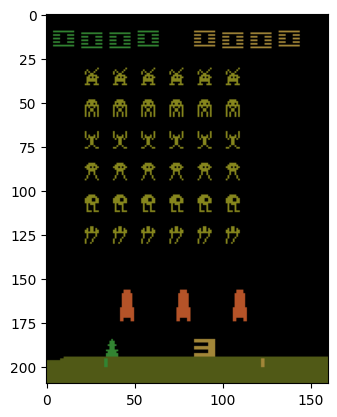

Preprocessed Frame


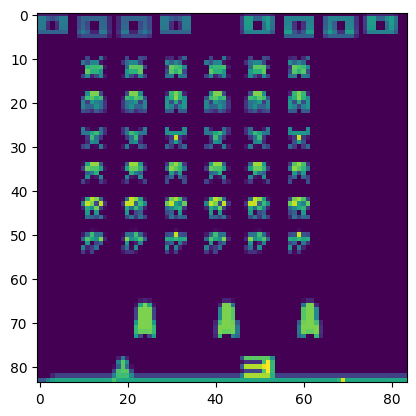

Preprocessed Frame (cmap=gray)


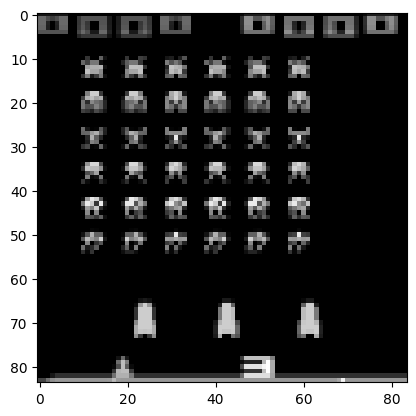

In [ ]:
env.reset()
for i in range(21):
    state, reward, terminated, truncated, info = env.step(1)

# Original frame
print("Original Frame")
plot_image(plt, state)

# Preprocessed frame
img = preprocess_frame(state, (8, -12, -12, 4), 84)
print("Preprocessed Frame")
plot_image(plt, img)
print("Preprocessed Frame (cmap=""gray"")")
plot_image(plt, img, cmap="gray")

##Stacking input game frames

In this environment, each action is repeatedly performed for a duration of k frames, where k is uniformly sampled from {2, 3, 4}. So, stacking frames is really important because it helps us to give a sense of motion to the neural network (stacking 4 frames together)

In [ ]:
def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.
        Params
        ======
            stacked_frames (array): Four Channel Stacked Frame
            frame: Preprocessed Frame to be added
            is_new: Is the state First
        """
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame

    return stacked_frames

In [ ]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), INPUT_SHAPE[1])
    frames = stack_frame(frames, frame, is_new)

    return frames

Frame 0


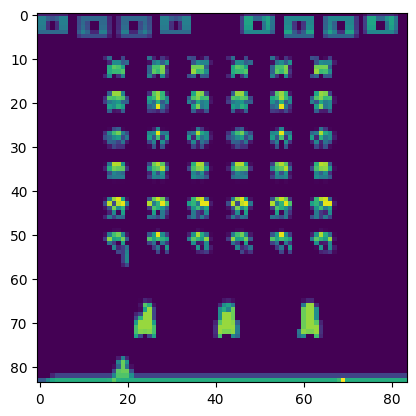

Frame 1


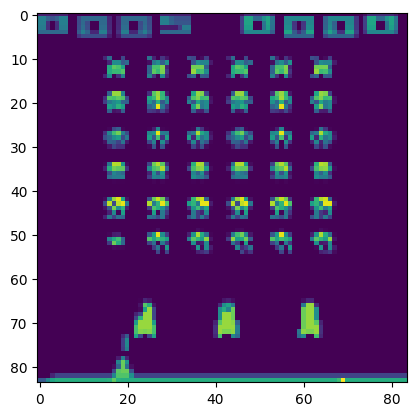

Frame 2


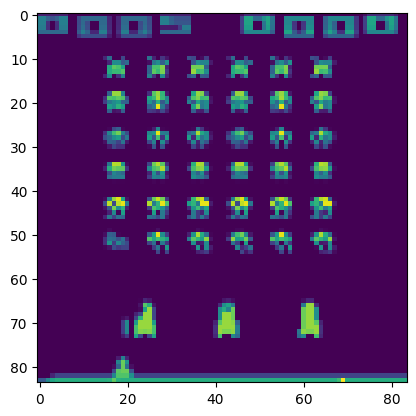

Frame 3


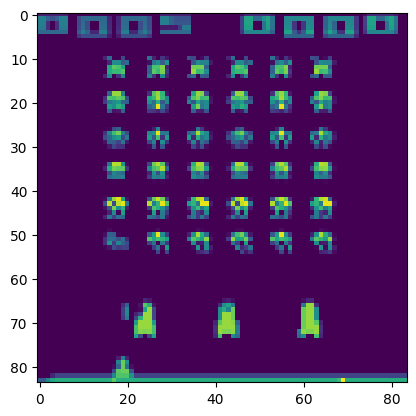

In [ ]:
env.reset()
for i in range(100):
    state, reward, terminated, truncated, info = env.step(1)

state = stack_frames(None, state, True)

# Storing frames
for i in range(4):
    next_state, reward, terminated, truncated, info = env.step(1)
    state = stack_frames(state, next_state, False)

# Plotting frames
for i in range(4):
    print("Frame " + str(i))
    plot_image(plt, state[i])

##Experience Replay Buffer

We will use **Experience Replay** in order to store the agent's experiences in the form $(s_t, a_t, r_t, s_{t+1})$:
- **state** $s_t$ in which the agent was in
- **action** $a_t$ the agent selected in that state
- **reward** $r_t$ received for taking the action in the state
- **next state** $s_{t+1}$ that the agent arrived to after action

After collecting a number **N** of these tuples $(s_t, a_t, r_t, s_{t+1})$, we randomly pass the data to train network.

In [ ]:
from collections import namedtuple, deque

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, max_length, batch_size, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            device (string): GPU or CPU
        """
        self.memory = deque(maxlen=max_length)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.device = device

        print("Replay Buffer started")
        print("Memory buffer=", max_length, ", batch size=", self.batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

##Neural network composed of linear layers

A neural network composed of linear layers to be used with Deep Q-learning algoritmh, combined with a convolutional layers.

The input size of the network receives the output of the convolutional layers.

The output of the network is the Q-value for each available action. So the output size is the shape of the actions state.

The size of the hidden layers is arbitrary. So, it can be varied from one application to another and it is one of the parameters that are worth modifying to ensure greater efficiency in the network.

In [ ]:
class LinearNetwork(nn.Module):
    """
    Linear neural network for Deep Q-learning
    """
    def __init__(self, observation_space_n, action_space_n):
        super(LinearNetwork, self).__init__()
        hidden_inputs = hidden_outputs = 512

        self.layers = nn.Sequential(
            nn.Linear(observation_space_n, hidden_inputs),
            nn.ReLU(),
            nn.Linear(hidden_inputs, hidden_outputs),
            nn.ReLU(),
            nn.Linear(hidden_outputs, action_space_n)
        )

        print("Linear neural network started")
        print("Input =", observation_space_n, ", Hidden inputs =", hidden_inputs, ", Hidden outputs =", hidden_outputs, ", Action number =", action_space_n)

    # Called with either one element to determine next action, or a batch during optimization
    # Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        return self.layers(state)

## Neural Network composed of convolutional layers

A neural network composed of convolutional layers to be used with Deep Q-learning algoritmh. It is useful for environments where we are receiving an image as observation.

The input must include a image shape (number of channels, height, width) received from the available environment. The number of channels consists of the number of frames for each image.

The output of the network is used as input for the linear layers, in order to compute the Q-value for each available action.

In [ ]:
import torch.autograd as autograd

class ConvolutionalNetwork(nn.Module):
    """
    Convolutional neural network for Deep Q-learning
    """
    def __init__(self, input_shape, action_space_n):

        super(ConvolutionalNetwork, self).__init__()
        self.input_shape = input_shape
        self.action_space_n = action_space_n

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=self.input_shape[0], out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        print("Convolutional neural network started")
        print("Shape =", self.input_shape)

        linear_input_size = self.layers_size()
        self.head = LinearNetwork(linear_input_size, self.action_space_n)

    def layers_size(self):
        return self.layers(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

    def forward(self, state):
        state = self.layers(state)
        state = state.view(state.size(0), -1)
        return self.head.forward(state)

##Building a Double Deep Q-learning agent (off-policy)

![alt_text](https://drive.google.com/uc?id=1gzIeLluw4fIYWtUKqo8WtsDYUCeq3xGp)

## (Double) Deep Q-learning Agent

In [ ]:
class DeepQLearningAgent:

    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float,
        batch_size: int,
        max_memory: int,
        tau: float,
        observation_space: int,
        action_space: int,
        input_shape: int,
        is_double_network: bool
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
            batch_size: The sample size for batch
            max_memory: The max number of iterations to be stored in memory buffer
            tau: The influence of local network on the target network
            observation_space: The observation space
            action_space: The action space
            input_shape: The shape of screen used as neural network input
            is_double_network: To use Deep Q-learning or Double Deep Q-learning algorithm
        """
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.batch_size = batch_size
        self.max_memory = max_memory
        self.tau = tau
        self.observation_space = observation_space
        self.action_space = action_space
        self.is_double_network = is_double_network
        self.input_shape = input_shape
        self.training_error = []

        # variables to control learning steps
        self.step_to_update = 0
        self.update_every = 100
        self.replay_after = 5000

        # Check that there is a GPU avaiable
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device available:", self.device)

        # Initialize experience replay buffer
        self.memory = ReplayBuffer(self.max_memory, self.batch_size, self.device)

        # These lines establish the convolutional and the linear part of the netwotk used to choose actions
        self.policy_dqn = ConvolutionalNetwork(self.input_shape, self.action_space.n).to(self.device)

        if(self.is_double_network):
            self.target_dqn = ConvolutionalNetwork(self.input_shape, self.action_space.n).to(self.device)
            self.target_dqn.eval()

            # Copy policy model parameters to target model parameters
            for target_param, policy_param in zip(self.target_dqn.parameters(), self.policy_dqn.parameters()):
                target_param.data.copy_(policy_param.data)

            print("Double Deep Q-learning agent started with PyTorch")
        else:
            print("Deep Q-learning agent started with PyTorch")

        # Initialize optimizer
        self.optimizer = optim.Adam(self.policy_dqn.parameters(), lr=self.learning_rate)
        print("Optimizer started")
        print("Learning rate=", self.learning_rate)

    def choose_action(self, state, is_evaluating=False):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if not is_evaluating and np.random.random() < self.epsilon:
            return self.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            state = torch.from_numpy(state).unsqueeze(0).to(self.device)
            self.policy_dqn.eval()
            with torch.no_grad():
                action_values = self.policy_dqn.forward(state)
            self.policy_dqn.train()
            return np.argmax(action_values.cpu().data.numpy())

    def remember(self, state, action, reward, next_state, is_terminal):
       # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, is_terminal)

    def update(self):
        # Learn every update_every time steps
        self.step_to_update = (self.step_to_update + 1) % self.update_every

        # If enough samples are available in memory, get random subset and learn
        if self.step_to_update != 0 or len(self.memory) <= self.replay_after:
            return

        # A sample of the training experiences
        (states, actions, rewards, next_states, dones) = self.memory.sample()

        # Get expected Q values from policy model
        Q1 = self.policy_dqn.forward(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Get max predicted Q values (for next states) from target model
        if(self.is_double_network):
            Q2 = self.target_dqn.forward(next_states).detach().max(1)[0]
        else:
            Q2 = self.policy_dqn.forward(next_states).detach().max(1)[0]

        # Compute Q targets for current states
        target = rewards + (1 - dones) * self.discount_factor * Q2

        # Compute loss
        temporal_difference_loss = F.mse_loss(Q1, target) # Mean Squared Error (MSE)
#        temporal_difference_loss = F.huber_loss(Q1, target) # Huber

        self.training_error.append(temporal_difference_loss.item())

        # Minimize the loss
        # Train the network using target and the predicted q_network values
        self.optimizer.zero_grad()
        temporal_difference_loss.backward()
        self.optimizer.step()

        if(self.is_double_network):
            # Update the target network by using the tau parameter
            for target_param, policy_param in zip(self.target_dqn.parameters(), self.policy_dqn.parameters()):
                target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

## Setting hyperparameters and initializing an agent

In [ ]:
learning_rate = 1e-4 # @param {type:"number"}
nb_max_episodes = 10 # @param {type:"integer"}
start_epsilon = 1.0 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes # reduce the exploration over time
discount_factor = 0.99 # @param {type:"number"}
batch_size = 32 # @param {type:"integer"}
max_memory = 100000 # @param {type:"integer"}
tau = 0.01 # @param {type:"number"}
test_freq = 50 # @param {type:"integer"}
is_double_network = True #@param {type:"boolean"}

agent = DeepQLearningAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor,
    batch_size=batch_size,
    max_memory=max_memory,
    tau=tau,
    observation_space=env.observation_space,
    action_space=env.action_space,
    input_shape=INPUT_SHAPE,
    is_double_network=is_double_network
)

Device available: cuda
Replay Buffer started
Memory buffer= 100000 , batch size= 32
Convolutional neural network started
Shape = (4, 84, 84)
Linear neural network started
Input = 3136 , Hidden inputs = 512 , Hidden outputs = 512 , Action number = 6
Convolutional neural network started
Shape = (4, 84, 84)
Linear neural network started
Input = 3136 , Hidden inputs = 512 , Hidden outputs = 512 , Action number = 6
Double Deep Q-learning agent started with PyTorch
Optimizer started
Learning rate= 0.0001


### Test accurracy

In [ ]:
def test_accurracy(num_episodes=100):
    counter = 0
    total_reward = 0.0

    while counter < num_episodes:
        state, info = env.reset()
        is_terminal = False

        state = stack_frames(None, state, True)

        while not is_terminal:
            action = agent.choose_action(state, True)

            next_state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            total_reward += reward

            state = stack_frames(state, next_state, False)

        counter += 1

    return total_reward/num_episodes

In [ ]:
# from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
def test_accurracy(num_episodes=100):
    counter = 0
    total_reward = 0.0

    while counter < num_episodes:
        state, info = env.reset()
        is_terminal = False

        state = stack_frames(None, state, True)

        while not is_terminal:
            action = agent.choose_action(state, True)

            next_state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            total_reward += reward

            state = stack_frames(state, next_state, False)

        counter += 1

    return total_reward/num_episodes

# def record_trained_video(video_file):
#     video = VideoRecorder(env, video_file)

#     # returns an initial observation
#     state, info = env.reset()
#     env.render()
#     video.capture_frame()
#     is_terminal = False
#     actions = env.env.get_action_meanings()

#     state = stack_frames(None, state, True)

#     while not is_terminal:
#         action = agent.choose_action(state, True)

#         next_state, reward, terminated, truncated, info = env.step(action)
#         is_terminal = terminated or truncated

#         state = stack_frames(state, next_state, False)

#         env.render()
#         video.capture_frame()

#         if(is_terminal):
#             print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
#             break

#     video.close()

## Playing and Training

In [ ]:
from tqdm import tqdm
from gymnasium.wrappers import RecordVideo

# Create a wrapped environment for recording the trained agent
env_trained_video = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
env_trained_video = RecordVideo(env_trained_video, video_folder="./trained_agent_video", episode_trigger=lambda x: x % test_freq == 0)


#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []
total_steps = 0
number_of_tests = 5


for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env_trained_video.reset() # Use the wrapped environment for training
    is_terminal = False
    total_reward = 0
    episode_step = 0

    state = stack_frames(None, state, True)

    # The Q-Network training
    while not is_terminal:
        episode_step += 1

        # Choose an action by greedily (with epsilon chance of random action) from the Q-Network
        action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env_trained_video.step(action) # Use the wrapped environment
        is_terminal = terminated or truncated

        next_state = stack_frames(state, next_state, False)

        # Store experience
        agent.remember(state, action, reward, next_state, is_terminal)

        # Train neural network based on ReplayBuffer
        agent.update()

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    # reduce exploration probability
    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        # evaluate the neural network by testing episodes
        accur = test_accurracy(number_of_tests)
        accuracies.append(accur)

        print('step: %s, episode: %s, training reward mean: %s, test reward mean: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

env_trained_video.close() # Close the wrapped environment
print("Trained agent video recorded in ./trained_agent_video")

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/trained_agent_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

Trained agent video recorded in ./trained_agent_video


In [ ]:
import glob
import os
from IPython.display import HTML

# You should get a video similar to the one below.
# Find the latest recorded video file in the ./trained_agent_video directory
video_files = glob.glob("./trained_agent_video/*.mp4")

if video_files:
    print(f"Found video files: {video_files}")
    # Sort files by modification time to get the latest
    latest_video_file = max(video_files, key=os.path.getmtime)
    print(f"Displaying latest video: {latest_video_file}")
    html = render_mp4(latest_video_file)
    display(HTML(html)) # Use display here
else:
    print("No trained agent video found in ./trained_agent_video.")

Found video files: ['./trained_agent_video/rl-video-episode-50.mp4', './trained_agent_video/rl-video-episode-0.mp4']
Displaying latest video: ./trained_agent_video/rl-video-episode-0.mp4


### Metrics

Training error list is empty, skipping plot.


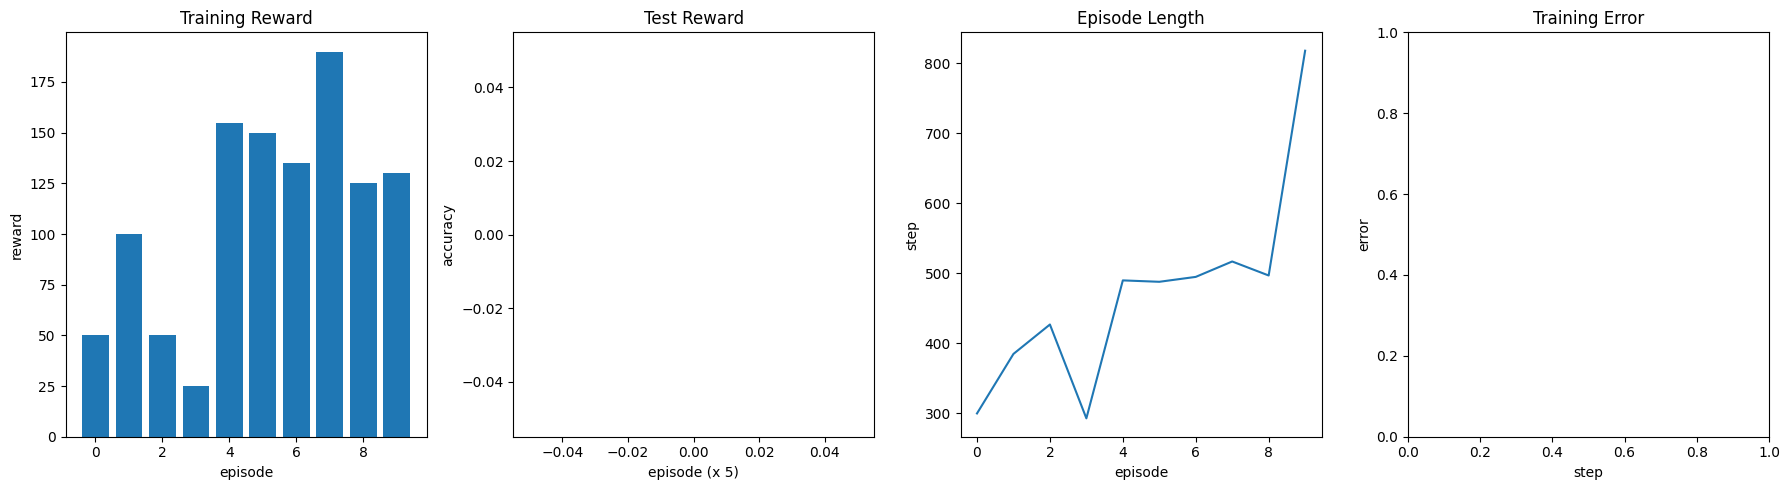

In [ ]:
rolling_length = 1
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x ' + str(number_of_tests) + ')')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
if agent.training_error: # Check if the list is not empty
    training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
    axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)
else:
    print("Training error list is empty, skipping plot.")


plt.tight_layout()
plt.show()